# 4-1. Image compression and Reconstruction via PCA




- 기수: 13기

- 이름: 이채원

- 작성자: 13기 강승우


_본 과제는 11기, 12기 Machine Learning과제를 참고하였음을 밝힙니다._


PCA는 고차원 데이터의 특징을 최대한 보존하면서 차원을 낮추기 위한 방법인 Dimensionality Reduction의 대표적인 method 중 하나입니다.

PCA는 결과적으로 원본 데이터의 Variance를 최대한 보존할 수 있는 Principal Component들을 찾는 것을 목표로 합니다. 그리고 선정한 Principal Component들은 모두 일정한 Explained Variance를 갖게 됩니다.

각 Principal Component의 설명력은 Covariance의 관점에서 PCA를 살펴보면 알 수 있습니다.

결국 Covariance Matrix에 대한 Eigenvalue Decomposition을 수행한 결과로써 PCA를 해석할 수 있는데, 이때 설명력이 높은 순서는 Eigenvalue의 크기가 큰 순서와 동일합니다.

본 과제 문제에서는 이러한 PCA의 간단한 구현과 Explained Variance 시각화에 대한 내용, 그리고 더 나아가 Reconstruction Error를 기반으로 한 간단한 Classification Task를 다룹니다.


## 1. Introduction: What is Reconstruction Error?


- **PCA Reconstruction은 어떻게 이루어지나요?**


<hr/>

Reduction을 거친 축소된 차원에서 다시 Principal Component를 사용한다면 원본 데이터를 복원할 수 있습니다. (PCA의 역연산)

그렇다면 Principal Component의 개수가 많을수록, 손실된 정보량이 적기 때문에 더욱 완벽한 원본 이미지를 복원할 수 있겠죠?


- **Reconstruction Error란 PCA를 이용한 Dimensionality Reduction 이후 다시 Dimension을 원래대로 Reconstruction하는 과정에서 발생하는 오차를 의미합니다.**


<hr/>

Dimensionality Reduction은 결국 정보량의 손실 (압축) 입니다. 아무리 Variance가 높게 Principal Component를 잘 설정한다 하더라도 정보량의 손실은 불가피합니다.

784차원의 데이터에 PCA를 적용하면서 Principal Component의 개수 $N$ 을 $10, 100, 250$ 각각으로 설정함에 따라 축소된 차원에서 보존되는 정보량이 늘어나게 됩니다.

또한 $N = 784$ 로 설정하게 되면 PCA를 진행하더라도, Dimension은 축소되지 않으며, 곧 정보량 또한 손실되지 않습니다.


- **그렇다면 고양이에 대한 데이터들에 대해 구한 Principal Component로 오토바이의 사진을 복원한다면 어떻게 될까요?**


<hr/>

간단하게 오토바이와 고양이의 사진들로 구성된 데이터셋이 있다고 가정해봅시다. 고양이들의 사진을 기준으로 PCA를 진행하기 위해 Principal Component를 구했습니다.

동일한 Principal Component로 오토바이 사진에 대해 Dimensionality Reduction과 Reconstruction을 진행한다면 어떻게 될까요?


- **당연히 Reconstruction Error는 오토바이 사진보다 고양이 사진에서 훨씬 더 낮을 것입니다!**


## 2. Load Dataset


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 3. Basic PCA


본 문제에서는 PCA 라이브러리가 아닌, 행렬 단위 연산을 통해 PCA 함수를 직접 구현하고자 합니다.

<hr/>


In [5]:
def compute_pca(X, n_components):
    selected_eigenvectors = np.zeros((X.shape[1], n_components))
    explained_variance = np.zeros(n_components)
    covariance_matrix = np.cov(X.T)  # mean-centered covariance


    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)  # for symmetric matrices

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:, idx]

    selected_eigenvectors = eigenvectors_sorted[:, :n_components]
    explained_variance = eigenvalues_sorted[:n_components] / np.sum(eigenvalues_sorted)


    return selected_eigenvectors, explained_variance


In [8]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Colab에서 파일 직접 업로드
uploaded = files.upload()   # 실행하면 파일 선택창이 뜸
img_path = list(uploaded.keys())[0]  # 업로드한 파일 이름

def plot_pca_recon(img_path=img_path, components_list=[5,10,50]):
    img = Image.open(img_path).convert("L")  # 흑백
    X = np.array(img).astype(float)          # (H, W)
    H, W = X.shape

    mu = X.mean(axis=0)
    Xc = X - mu

    fig, axes = plt.subplots(1, 1 + len(components_list), figsize=(5*(1+len(components_list)), 5))
    axes[0].imshow(X, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')

    explainded_variance = None
    for i, n in enumerate(components_list, start=1):
        if i < len(components_list):
            comps, _ = compute_pca(X, n)
        else:
            comps, explainded_variance = compute_pca(X, n)

        X_proj  = Xc @ comps
        X_recon = X_proj @ comps.T + mu
        X_recon = np.clip(X_recon, 0, 255)

        axes[i].imshow(X_recon, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f'PC = {n}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    return explainded_variance


Saving tralla.jpg to tralla.jpg


In [6]:
def plot_pca_recon(img_path='tralla.jpg', components_list=[5,10,50]):
    img = Image.open(img_path).convert("L")  # 흑백
    X = np.array(img).astype(float)          # (H, W)
    H, W = X.shape

    # 평균(열 기준) — 투영 전 중심화
    mu = X.mean(axis=0)
    Xc = X - mu

    fig, axes = plt.subplots(1, 1 + len(components_list), figsize=(5*(1+len(components_list)), 5))
    axes[0].imshow(X, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')

    explainded_variance = None  # 오탈자 그대로 반환 이름 맞춤
    for i, n in enumerate(components_list, start=1):
        if i < len(components_list):
            comps, _ = compute_pca(X, n)                    # (W, n)
        else:
            comps, explainded_variance = compute_pca(X, n)  # 마지막에 분산비율 받기

        # 투영( (H,W)@(W,n) -> (H,n) ) 후 복원( (H,n)@(n,W) + mu )
        X_proj  = Xc @ comps
        X_recon = X_proj @ comps.T + mu

        # 보기 좋게 클리핑
        X_recon = np.clip(X_recon, 0, 255)

        axes[i].imshow(X_recon, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f'PC = {n}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    return explainded_variance


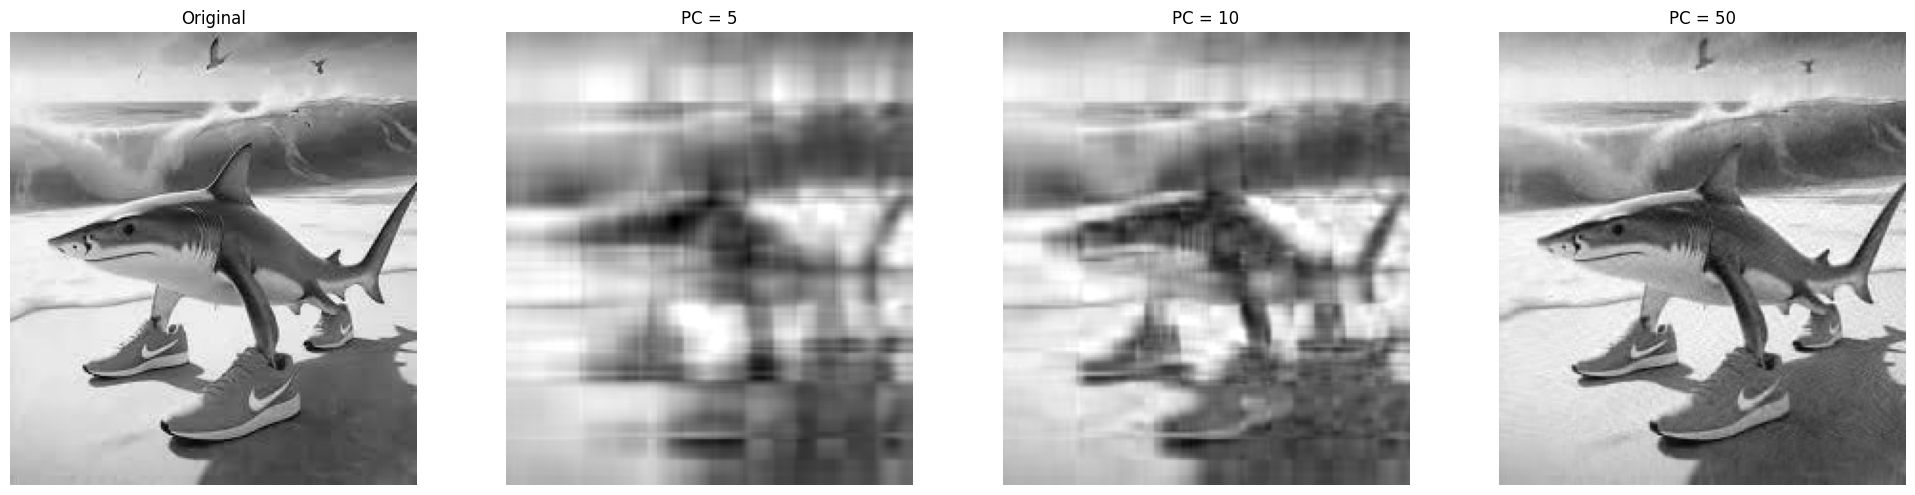

In [9]:
explained_variance = plot_pca_recon()

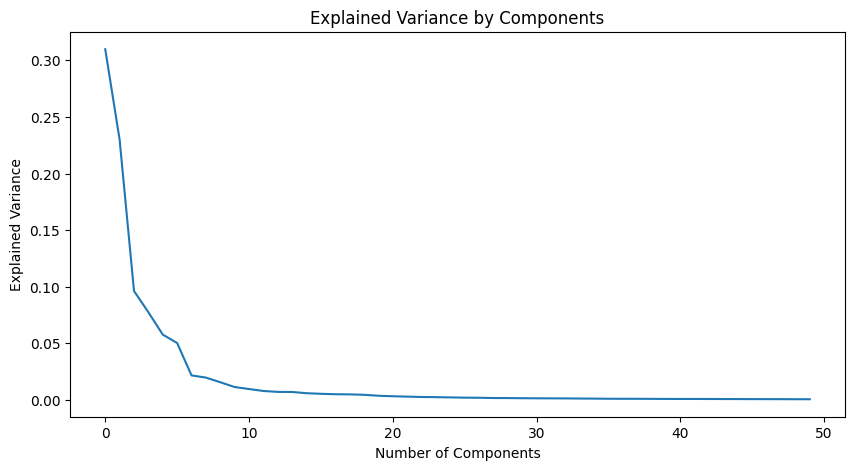

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

**작성한 함수 plot_pca_recon의 입력 이미지와 주성분 개수 리스트를 바꿔가며 실험해보세요!**


# 4-2. Denoising via PCA

In [12]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA

# 이미지는 16 x 16 크기의 흑백 이미지입니다.
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

In [14]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(4, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=12)

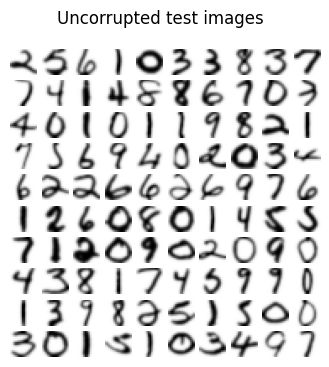

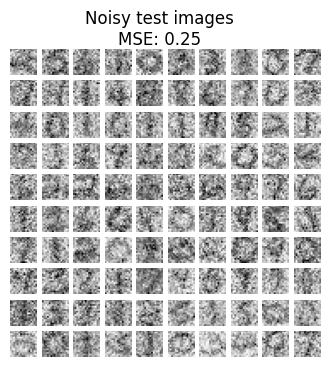

In [15]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

**PCA와 KPCA의 하이퍼파라미터를 적절히 조정하여 MSE(Reconstruction error)를 0.03이하로 만들어보세요!**

In [ ]:
pca = PCA(n_components=200, random_state=42)

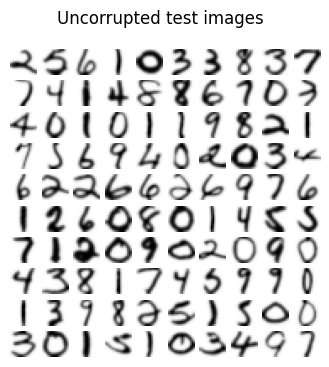

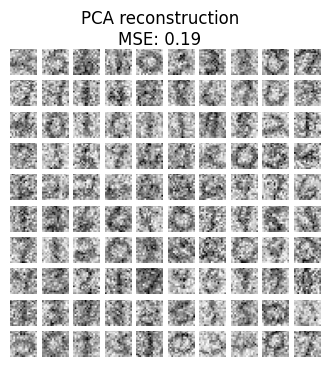

In [ ]:
pca.fit(X_train_noisy)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)

**주성분 개수(n_components)를 바꿔가며 출력해보았을 때,**

**노이즈 및 복원된 이미지와 어떤 관계를 갖는지 분석해보고 그 이유와 함께 아래에 작성해주세요!**

**(직접 주성분 개수를 증가, 반복시키며 plot하는 코드를 짜서 분석해도 좋습니다~)**

### **Analysis**
